## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024

See "Pitchers Adv Stats ML Thesis First Version.ipynb" first for a better understing of this notebook. 

Instead of using all the variables in our model, I will just select those who show a bigger correlation of 0.25 with the target variable 'AAV', and transforming those who show high multicolinearity. 


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Pitching\\adv\\Dataframes\\advperfpitch_all.csv"

try:
    df = pd.read_csv(file_path, encoding='latin1')
except UnicodeDecodeError:
    print("Error reading the file with 'latin1' encoding.")
    
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

On a previous step (in Excel) I created a few additional variables like Acc_G, VeloChange, Avg K/9, among others. The ones with Acc as a prefix are the sum of the same statistic in the two seasons. For example G + G_2 = Acc_G. 

For VeloChange I wanted to see the change in average mph thrown from one season to another. This will refelct if the pitcher is throwing faster or slower and we will see if teams pay attention to that. 

For the other variables with the suffix "Change" the thought process was the same. It will reflect the improvement (or otherwise) of the pitcher. 

### Handling the NULL values. 

In [4]:
columns = ['FIP', 'WAR', 'xFIP', 'WPA','SIERA', 'xERA', 'EV']

for column in columns:
    column_2 = f"{column}_2"
    
    df.loc[df[column_2].isnull() & df[column].notnull(), column_2] = df.loc[df[column_2].isnull() & df[column].notnull(), column]

    median_value = df[column].median()
    df.loc[df[column].isnull() & df[column_2].notnull(), column] = median_value

In [5]:
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

In [7]:
df['Acc_WAR'] = df['WAR'] + df['WAR_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165


In [8]:
df['Acc_WPA'] = df['WPA'] + df['WPA_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


## Feature Selection

In [9]:
removed_columns = ['PlayerId', 'year']
used_columns = df.columns[~df.columns.isin(removed_columns)]

df2 = df.drop(columns=removed_columns).copy()

df2.head()

,Name,AAV,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,34.877193,False,True,False,6,10,5,3.136364,1.060606,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,25.000000,False,True,False,11,8,8,1.790000,1.150000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,8.750000,False,True,False,7,5,1,2.283582,0.820896,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,24.571429,False,True,False,9,12,9,4.460000,1.150000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,5.000000,False,True,False,16,13,5,2.460000,1.060000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


### Correlation Matrix

In [10]:
numerical_columns = df2.select_dtypes(include=['number']).columns
boolean_columns = df2.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df2[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Acc_BS,Acc_G,Acc_GS,Acc_HLD,Acc_IP,Acc_QS,Acc_SO,Acc_SV,Acc_WAR,Acc_WPA,BB/9,BB/9Change,BB/9_2,BS,BS_2,ERA,ERAChange,ERA_2,EV,EV_2,FBv,FBv_2,FIP,FIP_2,G,GS,GS_2,G_2,HLD,HLD_2,HR/9,HR/9Change,HR/9_2,IP,IP_2,K/9,K/9Change,K/9_2,L,L_2,QS,QS_2,RP,SIERA,SIERA_2,SO,SO_2,SP,SV,SV_2,VeloChange,W,WAR,WAR_2,WHIP,WHIP_2,WPA,WPA_2,W_2,Yrs,minor_league,xERA,xERA_2,xFIP,xFIP_2
AAV,1.000000,-0.141774,-0.126680,0.481221,-0.231492,0.520056,0.588713,0.699078,0.109195,0.833589,0.536313,-0.233117,-0.055092,-0.186281,-0.093451,-0.157158,-0.268117,-0.122536,-0.139335,-0.065243,-0.047599,0.113450,0.157481,-0.342961,-0.230013,-0.055656,0.519264,0.374161,-0.164019,-0.164574,-0.237728,-0.140803,-0.079534,-0.029122,0.571719,0.314843,0.305915,0.020352,0.283678,0.310883,0.228153,0.642682,0.417008,-0.503318,-0.324951,-0.252234,0.720249,0.496335,0.408327,0.137674,0.068189,0.102403,0.621211,0.792543,0.630495,-0.331762,-0.226860,0.522665,0.311268,0.377868,0.146390,-0.351841,-0.316110,-0.184885,-0.437135,-0.347564
Acc_BS,-0.141774,1.000000,0.812708,-0.634561,0.616946,-0.410425,-0.566434,-0.298466,0.633576,-0.237913,0.192244,0.146751,0.083055,0.062090,0.883594,0.889483,-0.125227,0.066524,-0.250117,-0.108704,-0.128376,-0.020287,0.300204,-0.127850,-0.266038,0.702755,-0.570479,-0.605002,0.719721,0.560144,0.518228,-0.091571,0.071300,-0.182483,-0.340680,-0.354653,0.291783,-0.060503,0.349334,-0.222667,-0.220568,-0.484358,-0.525610,0.526251,-0.279831,-0.399019,-0.257121,-0.260068,-0.638076,0.557238,0.603441,-0.041506,-0.265322,-0.232426,-0.173673,-0.107750,-0.199297,0.104805,0.194086,-0.263054,-0.002054,-0.040098,-0.229198,-0.301249,-0.107119,-0.234637
Acc_G,-0.126680,0.812708,1.000000,-0.582224,0.753202,-0.279932,-0.507681,-0.179002,0.527385,-0.180348,0.276683,0.101128,0.030352,0.073450,0.711320,0.729511,-0.202499,0.045021,-0.310926,-0.163542,-0.190928,-0.027393,0.223850,-0.189869,-0.289734,0.870062,-0.523876,-0.554664,0.880433,0.673839,0.642186,-0.152845,0.054407,-0.218708,-0.235752,-0.238637,0.274215,-0.060196,0.331589,-0.184301,-0.185113,-0.432414,-0.472673,0.545955,-0.319330,-0.424798,-0.149673,-0.160305,-0.653245,0.479207,0.489085,-0.043223,-0.227657,-0.172050,-0.135822,-0.166929,-0.226370,0.183001,0.247187,-0.205963,0.056540,-0.088472,-0.289357,-0.350144,-0.154328,-0.250672
Acc_GS,0.481221,-0.634561,-0.582224,1.000000,-0.601443,0.907760,0.939304,0.817930,-0.366382,0.619242,-0.064570,-0.171970,-0.017526,-0.163786,-0.531575,-0.592849,0.091363,-0.011623,0.127290,0.095128,0.102142,0.058908,-0.238489,0.125400,0.140331,-0.493388,0.924731,0.928294,-0.525290,-0.528124,-0.522234,0.156057,-0.010720,0.163709,0.797598,0.742041,-0.214121,-0.041212,-0.171981,0.666432,0.631833,0.829081,0.847583,-0.772785,0.285694,0.285029,0.702931,0.714320,0.854608,-0.314119,-0.355939,0.075794,0.674827,0.523887,0.533733,0.034571,0.034934,-0.037466,-0.062926,0.680238,0.143710,-0.250167,0.197667,0.168238,0.080207,0.078280
Acc_HLD,-0.231492,0.616946,0.753202,-0.601443,1.000000,-0.402688,-0.539657,-0.342750,0.071809,-0.268268,0.178701,0.081621,-0.004294,0.092122,0.520482,0.572817,-0.154758,0.026855,-0.226331,-0.170430,-0.189569,-0.023972,0.150271,-0.162727,-0.225954,0.644909,-0.543221,-0.570969,0.673170,0.865747,0.880019,-0.146655,0.060236,-0.220529,-0.345263,-0.337395,0.212162,0.017294,0.193608,-0.285006,-0.293425,-0.461621,-0.500614,0.488927,-0.268454,-0.300231,-0.291173,-0.302570,-0.588694,0.075846,0.057480,-0.034603,-0.315886,-0.230521,-0.227633,-0.131620,-0.141316,0.133717,0.144134,-0.305982,-0.008491,-0.010688,-0.236169,-0.240106,-0.126094,-0.165554
Acc_IP,0.520056,-0.410425,-0.279932,0.907760,-0.402688,1.000000,0.899327,0.878631,-0.211825,0.668107,0.050438,-0.183798,-0.006622,-0.188862,-0.323258,-0.403507,0.019992,0.004671,0.017067,0.042356,0.037553,0.054952,-0.208084,0.061379,0.026663,-0.222325,0.840654,0.841476,-0.266887,-0.338316,-0.364157,0.116713,0.020278,0.084823,0.840641,0.853954,-0.154101,-0.068418,-0.085575,0.677465,0.649765,0.795062,0.810333,-0.657816,0.190785,0.148103,0.753

#### Interpreting the Correlation Matrix

##### 1. Clustering the Correlation Matrix

Clustering can help by grouping features with similar correlation patterns together. This can make the heatmap more interpretable.

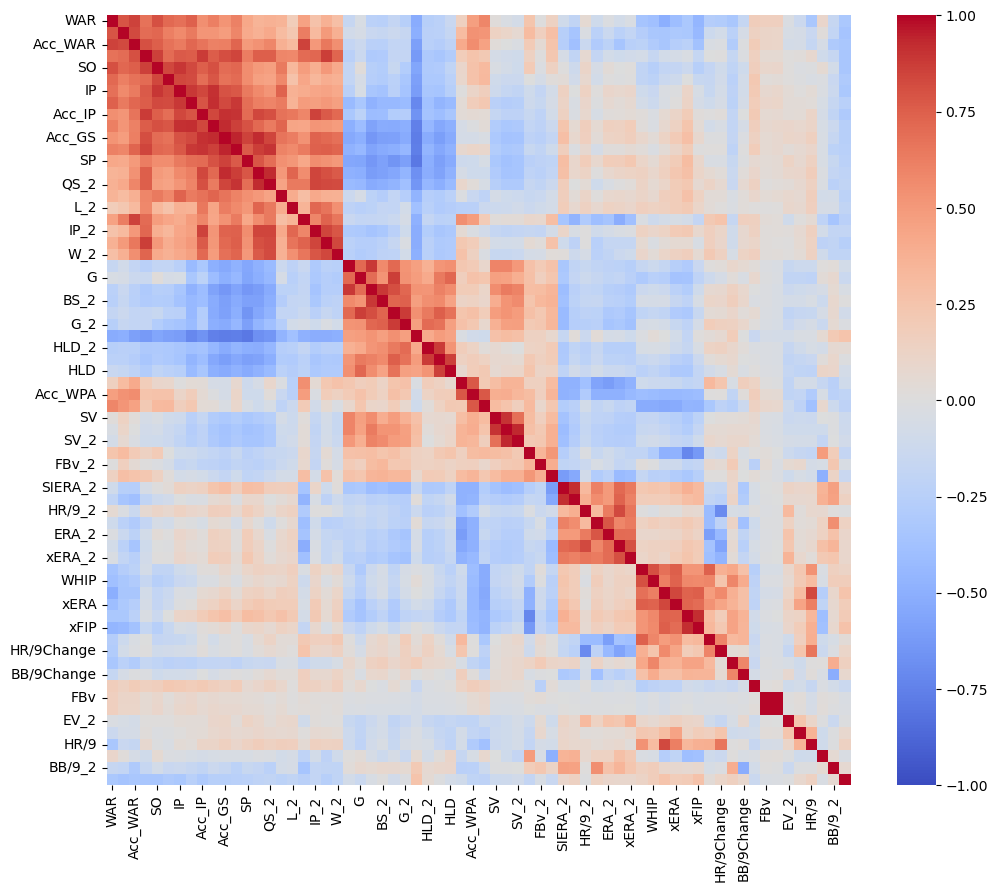

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(correlation_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = correlation_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('correlation_matrix_clustered.png')

plt.show()


##### 2. Filtering Significant Correlations

Filtering can highlight only the most significant correlations, making the heatmap less cluttered

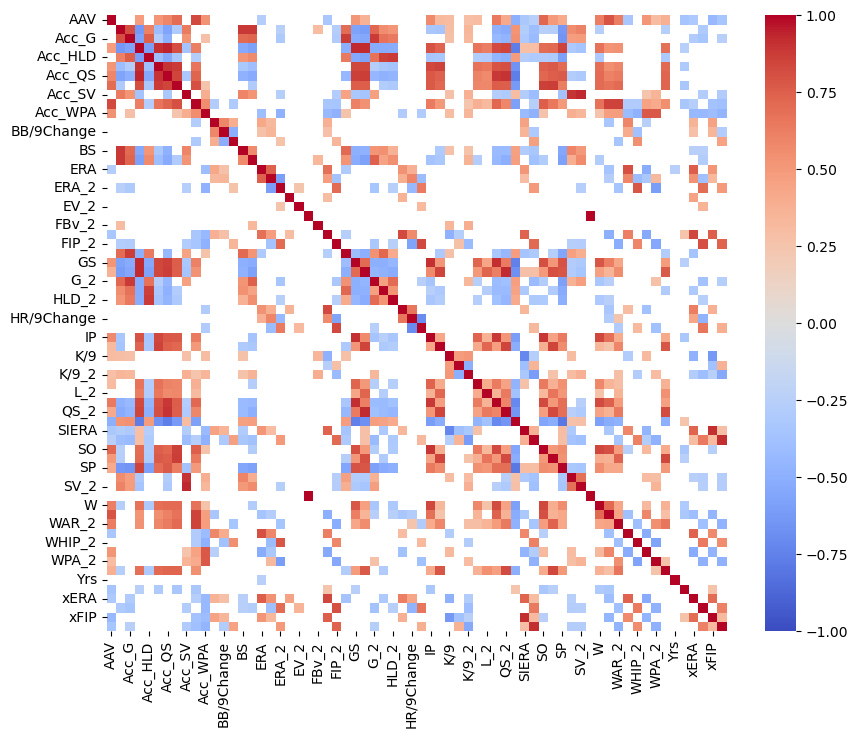

In [12]:
threshold = 0.25  
mask = correlation_matrix.abs() < threshold

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap="coolwarm", vmin=-1, vmax=1)


plt.savefig('correlation_matrix_filtered.png')

plt.show()

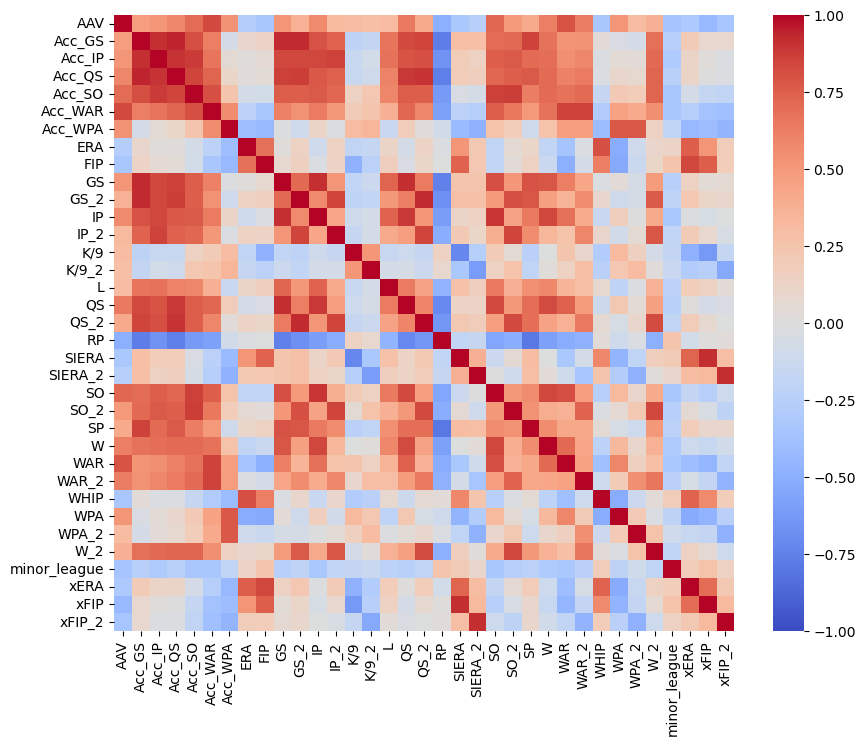

In [13]:
threshold = 0.25
aav_correlations = correlation_matrix['AAV']
filtered_columns = aav_correlations[(aav_correlations.abs() > threshold)].index

AAVfiltered_corr_matrix = df2[filtered_columns].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(AAVfiltered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('AAVfiltered_correlation_matrix.png')

plt.show()


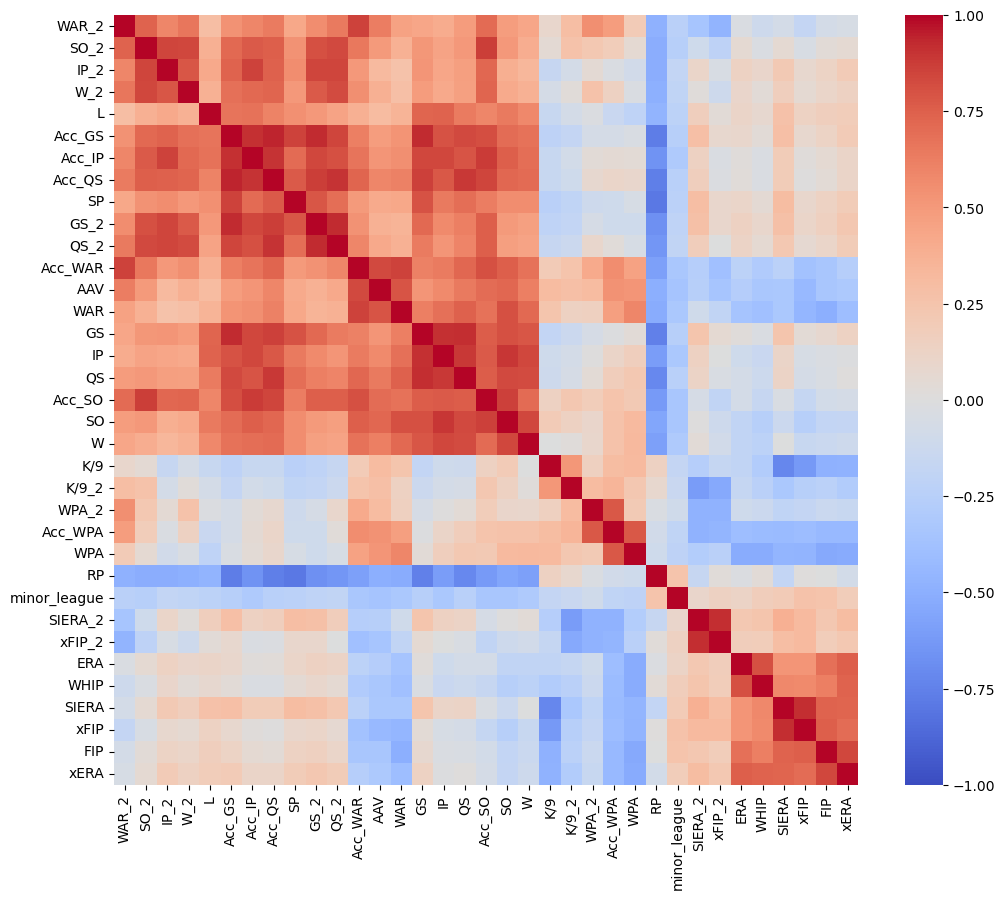

In [14]:
linked = linkage(AAVfiltered_corr_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = AAVfiltered_corr_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('AAVfiltered_correlation_matrix_clustered.png')

plt.show()



In [15]:
print(aav_correlations)

AAV             1.000000
Acc_BS         -0.141774
Acc_G          -0.126680
Acc_GS          0.481221
Acc_HLD        -0.231492
                  ...   
minor_league   -0.351841
xERA           -0.316110
xERA_2         -0.184885
xFIP           -0.437135
xFIP_2         -0.347564
Name: AAV, Length: 66, dtype: float64


Correlation of AAV with filtered variables:
                   AAV
Acc_GS        0.481221
Acc_IP        0.520056
Acc_QS        0.588713
Acc_SO        0.699078
Acc_WAR       0.833589
Acc_WPA       0.536313
ERA          -0.268117
FIP          -0.342961
GS            0.519264
GS_2          0.374161
IP            0.571719
IP_2          0.314843
K/9           0.305915
K/9_2         0.283678
L             0.310883
QS            0.642682
QS_2          0.417008
RP           -0.503318
SIERA        -0.324951
SIERA_2      -0.252234
SO            0.720249
SO_2          0.496335
SP            0.408327
W             0.621211
WAR           0.792543
WAR_2         0.630495
WHIP         -0.331762
WPA           0.522665
WPA_2         0.311268
W_2           0.377868
minor_league -0.351841
xERA         -0.316110
xFIP         -0.437135
xFIP_2       -0.347564


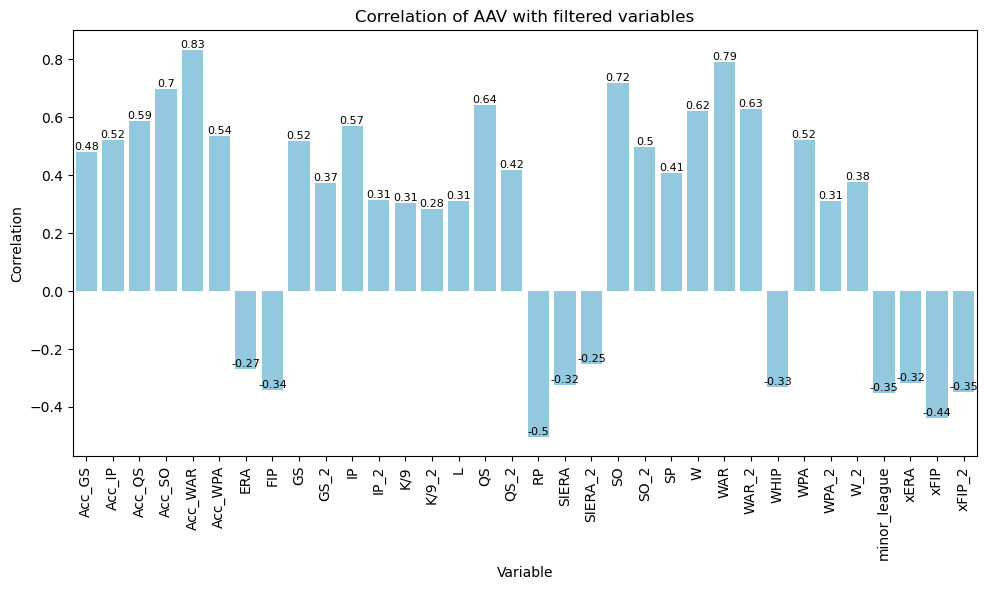

In [16]:
filtered_columns_without_aav = filtered_columns.drop('AAV', errors='ignore')
aav_correlations_filtered = AAVfiltered_corr_matrix.loc[['AAV'], filtered_columns_without_aav].transpose()
print("Correlation of AAV with filtered variables:")
print(aav_correlations_filtered)

plt.figure(figsize=(10, 6))
sns.barplot(x=aav_correlations_filtered.index, y=aav_correlations_filtered['AAV'],color='skyblue')


for i in range(len(aav_correlations_filtered)):
    plt.text(i, aav_correlations_filtered['AAV'][i], 
             round(aav_correlations_filtered['AAV'][i], 2), 
             ha='center', va='bottom', fontsize=8)
    
plt.xticks(rotation=90)
plt.title('Correlation of AAV with filtered variables')
plt.xlabel('Variable')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

#### Reducing and transforming high multicolinear variables 

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df2[['Acc_WAR', 'WAR', 'WAR_2']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   feature       VIF
0    const  1.791902
1  Acc_WAR       inf
2      WAR       inf
3    WAR_2       inf


C:\Users\mfran\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


The output shows infinite VIF values for Acc_WAR, WAR, and WAR_2, indicating perfect multicollinearity among these variables. This is expected because Acc_WAR is a direct linear combination of WAR and WAR_2.

Given this result, it is clear that we should not include all three variables in the model simultaneously. Including highly collinear variables can lead to issues in the model.

I will retain Only Acc_WAR: Since Acc_WAR has the highest correlation with the target variable and encapsulates the information from both WAR and WAR_2, the best approach would be to use only Acc_WAR and exclude WAR and WAR_2.


The same process will be done for the 'Acc' variables and also the ones ending in '_2'. Only the one with the highest colinearity will be kept. 



##### Wins and Losses

###### W_L_Ratio

To this model I want to add a W_L ratio and see its correlation with AAV

In [18]:
df2['Acc_W'] = df2['W'] + df2['W_2']
df2['Acc_L'] = df2['L'] + df2['L_2']

df2['W_L_Ratio'] = df2.apply(lambda row: row['Acc_W'] / row['Acc_L'] if row['Acc_L'] != 0 else float('inf') if row['Acc_W'] != 0 else 0, axis=1)
df2[['Acc_W', 'Acc_L', 'W_L_Ratio']].head()

,Acc_W,Acc_L,W_L_Ratio
0,25,14,1.785714
1,16,13,1.230769
2,18,5,3.600000
3,23,22,1.045455
4,25,8,3.125000


In [19]:
##filtered_df = df2[(df2['W_2'] == 0) & (df2['L_2'] == 0)]
filtered_df = df2[(df2['W_L_Ratio'] > 20) ]

filtered_df[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']]

,W,W_2,L,L_2,Acc_W,Acc_L,W_L_Ratio
162,1,0,0,0,1,0,inf
192,6,0,0,0,6,0,inf
239,1,3,0,0,4,0,inf
315,4,0,0,0,4,0,inf
417,6,1,0,0,7,0,inf
494,1,2,0,0,3,0,inf


In [20]:
df2['Acc_L'] = df2['Acc_L'].apply(lambda x: x + 1 if x == 0 else x)

df2['W_L_Ratio'] = df2['Acc_W'] / df2['Acc_L']

print(df2[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']].head())

correlation = df2['W_L_Ratio'].corr(df2['AAV'])
print(f'Correlation between W_L_Ratio and AAV: {correlation}')

    W  W_2  L  L_2  Acc_W  Acc_L  W_L_Ratio
0  10   15  5    9     25     14   1.785714
1   8    8  8    5     16     13   1.230769
2   5   13  1    4     18      5   3.600000
3  12   11  9   13     23     22   1.045455
4  13   12  5    3     25      8   3.125000
Correlation between W_L_Ratio and AAV: 0.154203420732014


The correlation seems to be low, but it encompasses what I believe is valuable information from two highly correlated variables with our target variable. We can also check the Wins and Losses per IP.

##### W/IP

In [21]:
df2['Acc_W/Acc_IP'] = df2.apply(lambda row: row['Acc_W'] / row['Acc_IP'] if row['Acc_W'] != 0 else 0, axis=1)

The correlation with the previous variables with AAV was the following:

In [22]:
df2['Acc_W'].corr(df2['AAV'])

0.600853713959533


And now, for the newly created Acc_W/Acc_IP, we have:


In [23]:
df2['Acc_W/Acc_IP'].corr(df2['AAV'])

0.16503181405789394

##### L/IP

In [24]:
df2['Acc_L/Acc_IP'] = df2.apply(lambda row: row['Acc_L'] / row['Acc_IP'] if row['Acc_L'] != 0 else 0, axis=1)

The correlation with the previous variables with AAV was the following:

In [25]:
df2['Acc_L'].corr(df2['AAV'])

0.32079088575348025


And now, for the newly created Acc_W/Acc_IP, we have:


In [26]:
df2['Acc_L/Acc_IP'].corr(df2['AAV'])

-0.12458836099969539

In a few more steps I will be using PCA to see if we can approach it through a different method and improve its correlation

#### Checking multicolinearity between the new variables created

In [27]:
X = df2[['W_L_Ratio','Acc_W/Acc_IP','Acc_L/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        feature        VIF
0         const  10.470128
1     W_L_Ratio   2.688482
2  Acc_W/Acc_IP   2.246703
3  Acc_L/Acc_IP   2.390856


In [28]:
X = df2[['Acc_W/Acc_IP','Acc_L/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

        feature       VIF
0         const  6.817819
1  Acc_W/Acc_IP  1.103288
2  Acc_L/Acc_IP  1.103288


There doesn't seem to be any correlation. For now, this means we will keep them. 

#### Checking multicolinearity between the different variables for time played

It is done taking into account the clustered correlation matrix done in the first steps.

In [29]:
X = df2[['Acc_GS', 'Acc_IP', 'Acc_QS','Acc_SO']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature        VIF
0   const   9.127966
1  Acc_GS  10.503032
2  Acc_IP   8.449072
3  Acc_QS  10.464008
4  Acc_SO   4.884434


In [30]:
X = df2[['IP', 'QS']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0   const  5.359859
1      IP  4.645125
2      QS  4.645125


#### Creating new variables for 'time played' multicolinearity

The objective is to create new variables that will help us keep the highly correlated variables while avoiding the multicolinearity between them. 

##### QSs per IPs

The first of them will be Quality Starts per Innings Pitched. I believe it doesn't need much explanation. It is the amount of QS per IP a pitcher has. For RPs the number will be 0, as many of them don't have any Games Started and for that reason no Quality Starts. We already have a dummy variable that indicates whether a pitcher is a starting pitcher or not. This can help the model differentiate between starting and relief pitchers.

In [31]:
df2['Acc_QS/Acc_IP'] = df2.apply(lambda row: row['Acc_QS'] / row['Acc_IP'] if row['Acc_QS'] != 0 else 0, axis=1)

The correlation with the previous variables with AAV was the following:

Acc_IP        0.520056

Acc_QS        0.588713

And now, for the newly created Acc_QS/Acc_IP, we have:


In [32]:
df2['Acc_QS/Acc_IP'].corr(df2['AAV'])

0.5182512334695608

A 0.51825 correlation shows us it is keeping the correlation with AAV while avoiding multicolinearity. 

In [33]:
df2['Acc_GS/Acc_IP'] = df2.apply(lambda row: row['Acc_GS'] / row['Acc_IP'] if row['Acc_GS'] != 0 else 0, axis=1)

The correlation with the previous variables with AAV was the following:

Acc_GS        0.481221

And now, for the newly created Acc_GS/Acc_IP, we have:


In [34]:
df2['Acc_GS/Acc_IP'].corr(df2['AAV'])

0.33417241331028735

##### SO per IP

In [35]:
df2['Acc_SO/Acc_IP'] = df2.apply(lambda row: row['Acc_SO'] / row['Acc_IP'], axis=1)

The correlation with the previous variables with AAV was the following:

Acc_SO        0.699078

And now, for the newly created Acc_SO/Acc_IP, we have:

In [36]:
df2['Acc_SO/Acc_IP'].corr(df2['AAV'])

0.1571615717263439

This feels low, but it is also a repetition of the two already existing variables K/9 and K/9_2, as they measure the same aspect: strikeouts per certain amount of innings. Their correlation with AAV is the following:

K/9           0.305915

K/9_2         0.283678


It is higher, so there's no need to keep SO in our model. 


#### Principal Component Analysis (PCA)

K/9 and K/9_2 are telling us almost the same information. Pitchers don't drastically improve or worsen their K rate from season to season. For this case I want to try implementing Principal Component Analysis. 

PCA is a technique to transform the original variables into a new set of variables (principal components) that are orthogonal and can capture the maximum variance. This method might be useful when we have more than two correlated predictors and want to reduce dimensionality.

In [37]:
from sklearn.decomposition import PCA

X = df2[['K/9', 'K/9_2']]

pca = PCA(n_components=1)
df2['K/9_combined'] = pca.fit_transform(X)

In [38]:
df2['K/9_combined'].corr(df2['AAV'])

0.3390309236087219

Let's try it with the QS per IP case, and see if it performs better than the variable created. 

In [39]:
df_dummy = df2.copy()

In [40]:
from sklearn.decomposition import PCA

X = df_dummy[['Acc_QS', 'Acc_IP']]

pca = PCA(n_components=1)
df_dummy['dummy'] = pca.fit_transform(X)

In [41]:
df_dummy['dummy'].corr(df_dummy['AAV'])

0.5215672480974177

It is very similar to Acc_QS/Acc_IP's 0.5182512334695608. I'm keeping the variable we created.

But for those variables that show correlation with AAV but are a repetition of its most recent season, I will apply PCA. 

Also, I'm applying this approach to the W/IP and L/IP variables to see if the correlation with AAV improves.

##### W / L / IP with PCA 

In [42]:
from sklearn.decomposition import PCA

X = df_dummy[['Acc_W', 'Acc_IP']]

pca = PCA(n_components=1)
df_dummy['dummy2'] = pca.fit_transform(X)

In [43]:
df_dummy['dummy2'].corr(df_dummy['AAV'])

0.5207956469976605

In [44]:
from sklearn.decomposition import PCA

X = df_dummy[['Acc_L', 'Acc_IP']]

pca = PCA(n_components=1)
df_dummy['dummy3'] = pca.fit_transform(X)

In [45]:
df_dummy['dummy3'].corr(df_dummy['AAV'])

0.5197799338928626

In [46]:
X = df_dummy[['dummy2','dummy3','Acc_GS/Acc_IP', 'Acc_QS/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature            VIF
0          const       2.450811
1         dummy2  111496.412537
2         dummy3  111309.639344
3  Acc_GS/Acc_IP       4.723595
4  Acc_QS/Acc_IP       6.494954


Having them separated shows us theres a perfect colinearity between them. 

In [47]:
X = df_dummy[['Acc_W/Acc_IP','Acc_L/Acc_IP','Acc_GS/Acc_IP', 'Acc_QS/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

         feature       VIF
0          const  7.171513
1   Acc_W/Acc_IP  1.171515
2   Acc_L/Acc_IP  1.312881
3  Acc_GS/Acc_IP  4.966816
4  Acc_QS/Acc_IP  4.971900


But, that wasn't the case for Acc_W/Acc_IP & Acc_L/Acc_IP 

In [48]:
X = df_dummy[['Acc_W','Acc_L', 'Acc_IP']]

pca = PCA(n_components=1)
df_dummy['dummy4'] = pca.fit_transform(X)

In [49]:
df_dummy['dummy4'].corr(df_dummy['AAV'])

0.5205191220647031

In [50]:
X = df_dummy[['dummy4','Acc_GS/Acc_IP', 'Acc_QS/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature       VIF
0          const  2.433351
1         dummy4  2.054241
2  Acc_GS/Acc_IP  4.210915
3  Acc_QS/Acc_IP  5.512423


To have W/L and IP, while maintaing a high correlation with AAV, I tried implementing PCA for the 3 variables. It shows a high correlation and not a significant multicolinearity with the other newly created variables. I'll pass it onto the original df instead of the dummy df. 

In [51]:
X = df2[['Acc_W','Acc_L', 'Acc_IP']]

pca = PCA(n_components=1)
df2['W/L/IP_combined'] = pca.fit_transform(X)

Just to check everything is still the same:

In [52]:
df2['W/L/IP_combined'].corr(df_dummy['AAV'])

0.5205191220647029

In [53]:
X = df2[['W/L/IP_combined','Acc_GS/Acc_IP', 'Acc_QS/Acc_IP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

           feature       VIF
0            const  2.433351
1  W/L/IP_combined  2.054241
2    Acc_GS/Acc_IP  4.210915
3    Acc_QS/Acc_IP  5.512423


##### SIERA_2 and xFIP_2

Correlation between them:

In [54]:
df2['SIERA_2'].corr(df2['xFIP_2'])

0.9200988758012367

But why not with SIERA? The filtered clustered correlation matrix doesn't show a high correlation between them. We can validate it:

In [55]:
df2['SIERA_2'].corr(df2['SIERA'])

0.37685917147683745

Correlation with AAV

xFIP_2       -0.347564

SIERA_2      -0.252234


In [56]:
X = df2[['xFIP_2', 'SIERA_2']]

pca = PCA(n_components=1)
df2['xFIP_2-SIERA_2'] = pca.fit_transform(X)

In [57]:
df2['xFIP_2-SIERA_2'].corr(df2['AAV'])

0.30590569531048845

Why is it not negative as the individual variables?

PCA does not necessarily preserve the individual variable correlations with the target variable. Instead, it optimizes for capturing variance in a different way that might better explain the relationship with the target variable in the context of all variables.

##### ERA-WHIP

In [58]:
df2['ERA'].corr(df2['WHIP'])

0.8065635408310684

They show high correlation between each other but we know they measure different things. While ERA measures the runs allowed by the pitcher, WHIP measures the Walks and Hits the pitcher allows. But in the ends there's no runs without walks or hits. I will be transforming them and see if shows better correlation with AAV

Correlation with AAV

WHIP         -0.331762

ERA          -0.268117


In [59]:
X = df2[['ERA', 'WHIP']]

pca = PCA(n_components=1)
df2['ERA-WHIP'] = pca.fit_transform(X)

In [60]:
df2['ERA-WHIP'].corr(df2['AAV'])

-0.2705258450999737

##### SIERA-XFIP

In [61]:
df2['SIERA'].corr(df2['xFIP'])

0.9179154650064368

Correlation with AAV

SIERA        -0.324951

xFIP         -0.437135

In [62]:
X = df2[['SIERA', 'xFIP']]

pca = PCA(n_components=1)
df2['SIERA-xFIP'] = pca.fit_transform(X)

In [63]:
df2['SIERA-xFIP'].corr(df2['AAV'])

0.3894423826798984

##### FIP-XERA

In [64]:
df2['xERA'].corr(df2['FIP'])

0.8359879597001144

Correlation with AAV

xERA         -0.316110

FIP          -0.342961

In [65]:
X = df2[['xERA', 'FIP']]

pca = PCA(n_components=1)
df2['xERA-FIP'] = pca.fit_transform(X)

In [66]:
df2['xERA-FIP'].corr(df2['AAV'])

-0.34362871041853216

In [67]:
X = df2[['xFIP_2-SIERA_2','ERA-WHIP', 'SIERA-xFIP','xERA-FIP']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

          feature       VIF
0           const  1.000000
1  xFIP_2-SIERA_2  1.134727
2        ERA-WHIP  2.359455
3      SIERA-xFIP  2.729424
4        xERA-FIP  4.273361


### Feature Selection Pt 2. 

We have transformed the entire dataset. Now its time to prove if these new variables will perform better than our initial models. 

We will keep those from 'filtered_columns' that weren't touched like Acc WAR, SP, RP, etc. And we will add those new variables created. 

In [68]:
print(filtered_columns)

Index(['AAV', 'Acc_GS', 'Acc_IP', 'Acc_QS', 'Acc_SO', 'Acc_WAR', 'Acc_WPA',
       'ERA', 'FIP', 'GS', 'GS_2', 'IP', 'IP_2', 'K/9', 'K/9_2', 'L', 'QS',
       'QS_2', 'RP', 'SIERA', 'SIERA_2', 'SO', 'SO_2', 'SP', 'W', 'WAR',
       'WAR_2', 'WHIP', 'WPA', 'WPA_2', 'W_2', 'minor_league', 'xERA', 'xFIP',
       'xFIP_2'],
      dtype='object')


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             508 non-null    object 
 1   AAV              508 non-null    float64
 2   minor_league     508 non-null    bool   
 3   SP               508 non-null    bool   
 4   RP               508 non-null    bool   
 5   Yrs              508 non-null    int64  
 6   W                508 non-null    int64  
 7   L                508 non-null    int64  
 8   ERA              508 non-null    float64
 9   WHIP             508 non-null    float64
 10  G                508 non-null    int64  
 11  GS               508 non-null    int64  
 12  QS               508 non-null    int64  
 13  SV               508 non-null    int64  
 14  BS               508 non-null    int64  
 15  HLD              508 non-null    int64  
 16  IP               508 non-null    float64
 17  SO              

In [70]:
df3 = df2.loc[:, ['AAV', 'Acc_WAR', 'Acc_WPA', 'RP', 'SP', 'minor_league',
                          'Acc_W/Acc_IP', 'Acc_L/Acc_IP', 'Acc_QS/Acc_IP', 'Acc_GS/Acc_IP',
                          'Acc_SO/Acc_IP', 'K/9_combined', 'W/L/IP_combined',
                          'xFIP_2-SIERA_2', 'ERA-WHIP', 'SIERA-xFIP', 'xERA-FIP']]

df3.head() 

,AAV,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP
0,34.877193,7.966784,5.364157,False,True,False,0.083893,0.046980,0.093960,0.171141,1.295302,4.007966,143.055160,1.897260,-1.027840,0.679122,-0.363038
1,25.000000,7.645342,3.818644,False,True,False,0.052770,0.042876,0.085752,0.184697,0.989446,0.108854,147.624250,0.480458,-2.350933,0.429639,-1.296236
2,8.750000,5.001775,3.346239,False,True,False,0.081781,0.022717,0.099955,0.172649,1.199455,2.479014,64.522833,1.347569,-1.904654,0.795983,-1.357324
3,24.571429,10.192750,2.951880,False,True,False,0.057760,0.055249,0.082873,0.160723,1.097438,1.500089,243.202332,1.765051,0.296114,0.578714,-0.419301
4,5.000000,6.191165,4.462551,False,True,False,0.097163,0.031092,0.089390,0.178780,1.064905,1.080285,102.191237,1.597326,-1.698468,0.573998,-0.376268


### Correlation Matrix

In [71]:
numerical_columns = df3.select_dtypes(include=['number']).columns
boolean_columns = df3.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df3[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Acc_GS/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_SO/Acc_IP,Acc_W/Acc_IP,Acc_WAR,Acc_WPA,ERA-WHIP,K/9_combined,RP,SIERA-xFIP,SP,W/L/IP_combined,minor_league,xERA-FIP,xFIP_2-SIERA_2
AAV,1.000000,0.334172,-0.124588,0.518251,0.157162,0.165032,0.833589,0.536313,-0.270526,0.339031,-0.503318,0.389442,0.408327,0.520519,-0.351841,-0.343629,0.305906
Acc_GS/Acc_IP,0.334172,1.000000,0.150916,0.872553,-0.036096,0.107099,0.418000,-0.156462,0.156171,-0.255636,-0.716701,-0.233880,0.852634,0.599663,-0.193961,0.215241,-0.254874
Acc_L/Acc_IP,-0.124588,0.150916,1.000000,-0.027647,0.500772,0.305971,-0.155622,-0.278582,0.194263,0.048127,0.070321,-0.109416,0.000472,-0.184726,0.024395,0.141696,-0.051017
Acc_QS/Acc_IP,0.518251,0.872553,-0.027647,1.000000,-0.070810,0.148270,0.621905,0.051725,0.061765,-0.190760,-0.776182,-0.134142,0.829228,0.714701,-0.223651,0.112528,-0.115426
Acc_SO/Acc_IP,0.157162,-0.036096,0.500772,-0.070810,1.000000,0.607378,0.119794,0.266704,-0.138850,0.572409,0.098918,0.294949,-0.146741,-0.290053,-0.080343,-0.249655,0.306554
Acc_W/Acc_IP,0.165032,0.107099,0.305971,0.148270,0.607378,1.000000,0.175297,0.234164,-0.067339,0.164059,-0.097064,0.064184,0.036951,-0.083510,-0.091633,-0.074936,0.159548
Acc_WAR,0.833589,0.418000,-0.155622,0.621905,0.119794,0.175297,1.000000,0.557686,-0.226466,0.260459,-0.591198,0.307096,0.496440,0.668558,-0.328948,-0.313797,0.330243
Acc_WPA,0.536313,-0.156462,-0.278582,0.051725,0.266704,0.234164,0.557686,1.000000,-0.405126,0.374541,-0.086239,0.427740,-0.103578,0.050571,-0.199209,-0.453676,0.483100
ERA-WHIP,-0.270526,0.156171,0.194263,0.061765,-0.138850,-0.067339,-0.226466,-0.405126,1.000000,-0.212034,-0.016813,-0.531634,0.103041,0.019207,0.124391,0.753391,-0.202977
K/9_combined,0.339031,-0.255636,0.048127,-0.190760,0.572409,0.164059,0.260459,0.374541,-0.212034,1.000000,0.132434,0.565230,-0.249611,-0.137074,-0.186013,-0.442896,0.463902


#### Interpreting the Correlation Matrix

##### 1. Clustering the Correlation Matrix

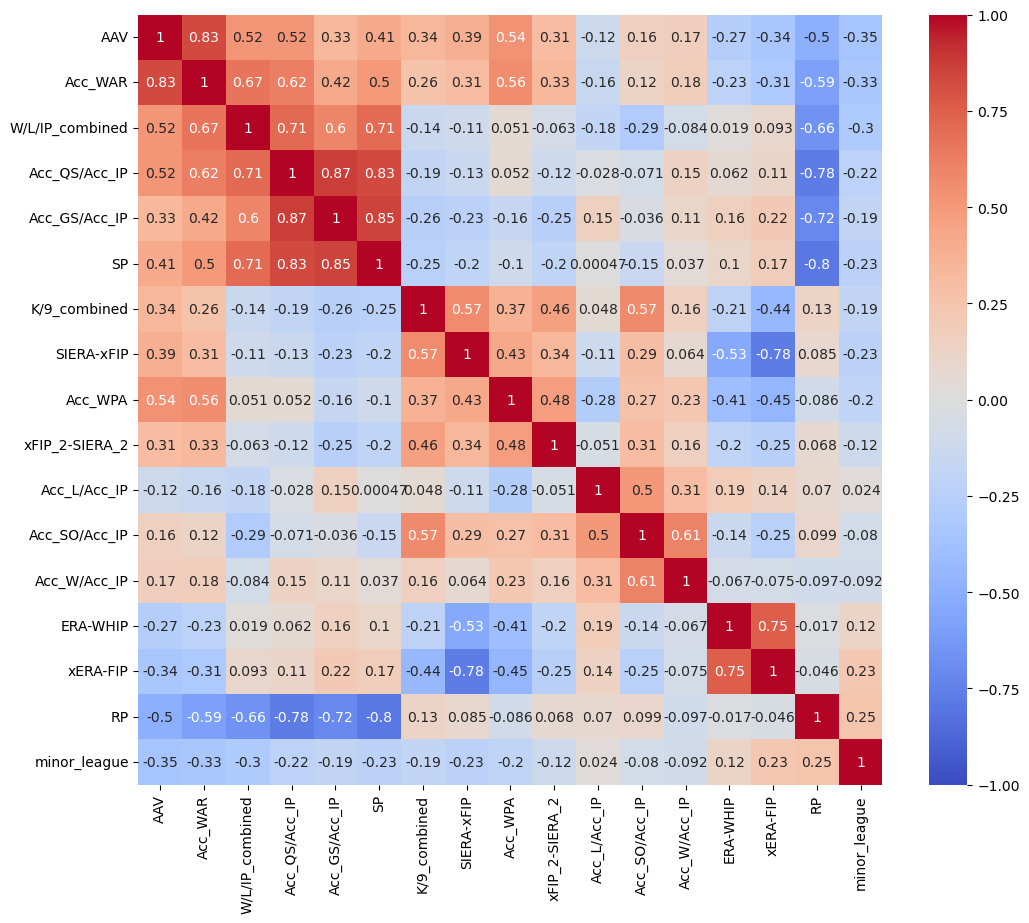

In [72]:
linked = linkage(correlation_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = correlation_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('correlation_matrix_clustered.png')

plt.show()


In [73]:
aav_correlations = correlation_matrix['AAV']

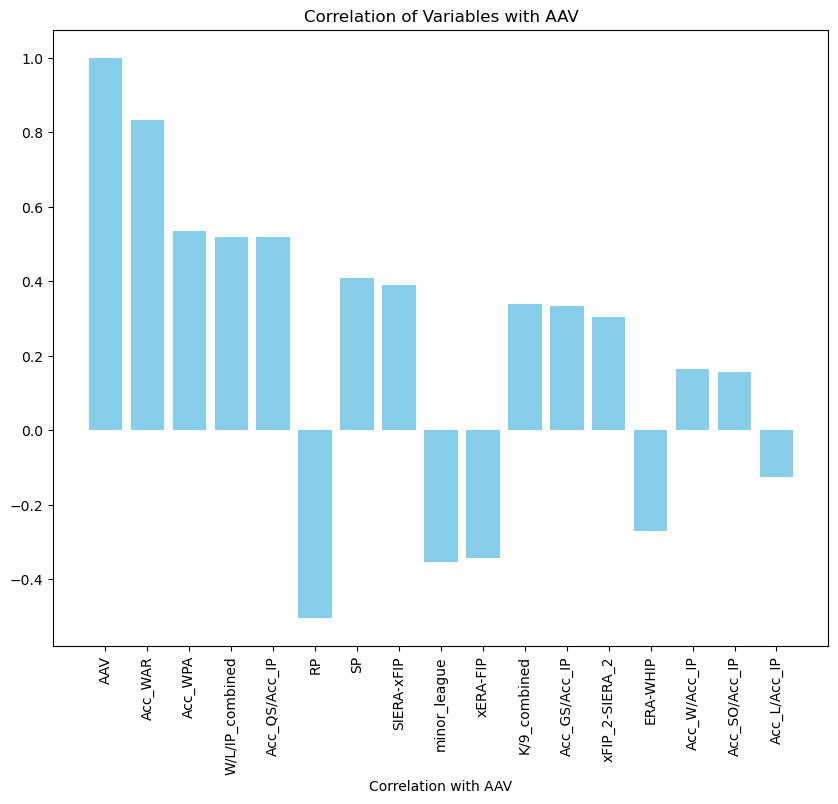

In [74]:
sorted_correlations = sorted(aav_correlations.items(), key=lambda x: abs(x[1]), reverse=True)
variables = [item[0] for item in sorted_correlations]
correlations = [item[1] for item in sorted_correlations]

plt.figure(figsize=(10, 8))
plt.bar(variables, correlations, color='skyblue')
plt.xlabel('Correlation with AAV')
plt.title('Correlation of Variables with AAV')
plt.grid(axis='x', linestyle='', alpha=0.7)
plt.xticks(rotation=90)

plt.show()

## Train-test split

For the train-test we will be using different combinations: 80-20 and 70-30. They won't be reproducted in different cells, but the results will be kept in different tables for comparison. To obtain this we modify 'test_size=0.2' 0.2 or 0.3 depending on the combination. 

In [75]:
target = "AAV"
features = [col for col in df3.columns if col != target]
X, y = df3[features], df3[target]

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (355, 16)
X_test shape: (153, 16)
y_train shape: (355,)
y_test shape: (153,)


C:\Users\mfran\AppData\Local\Temp\ipykernel_18660\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


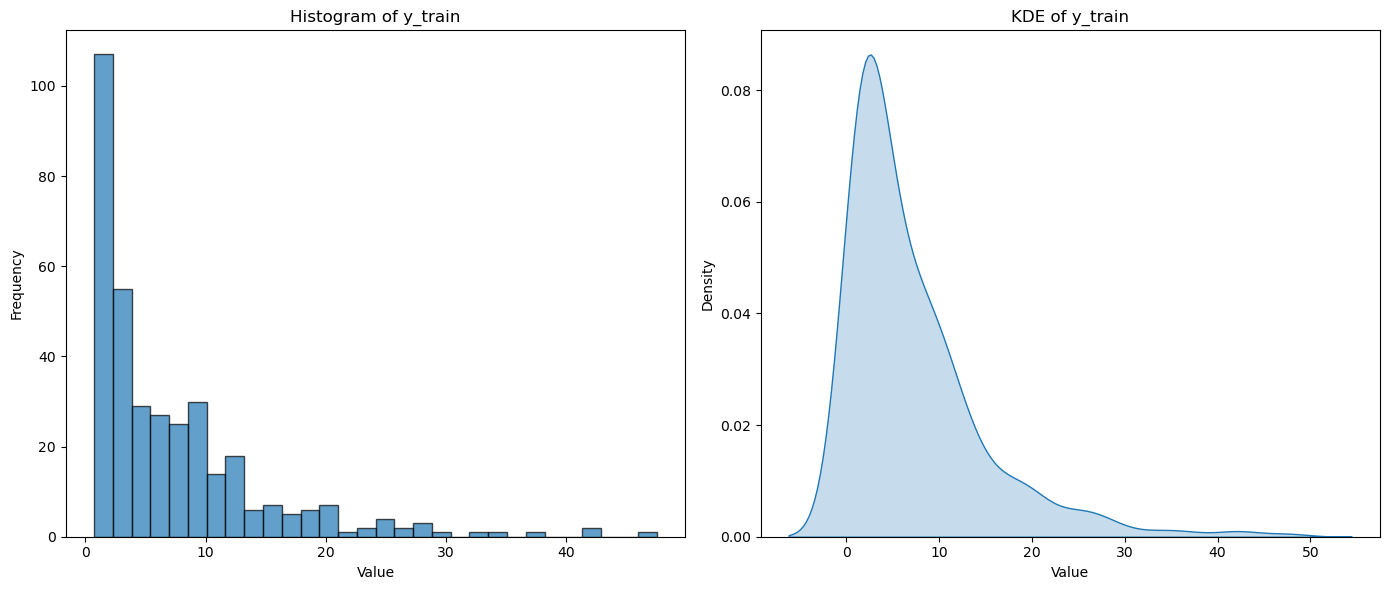

In [77]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\mfran\AppData\Local\Temp\ipykernel_18660\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


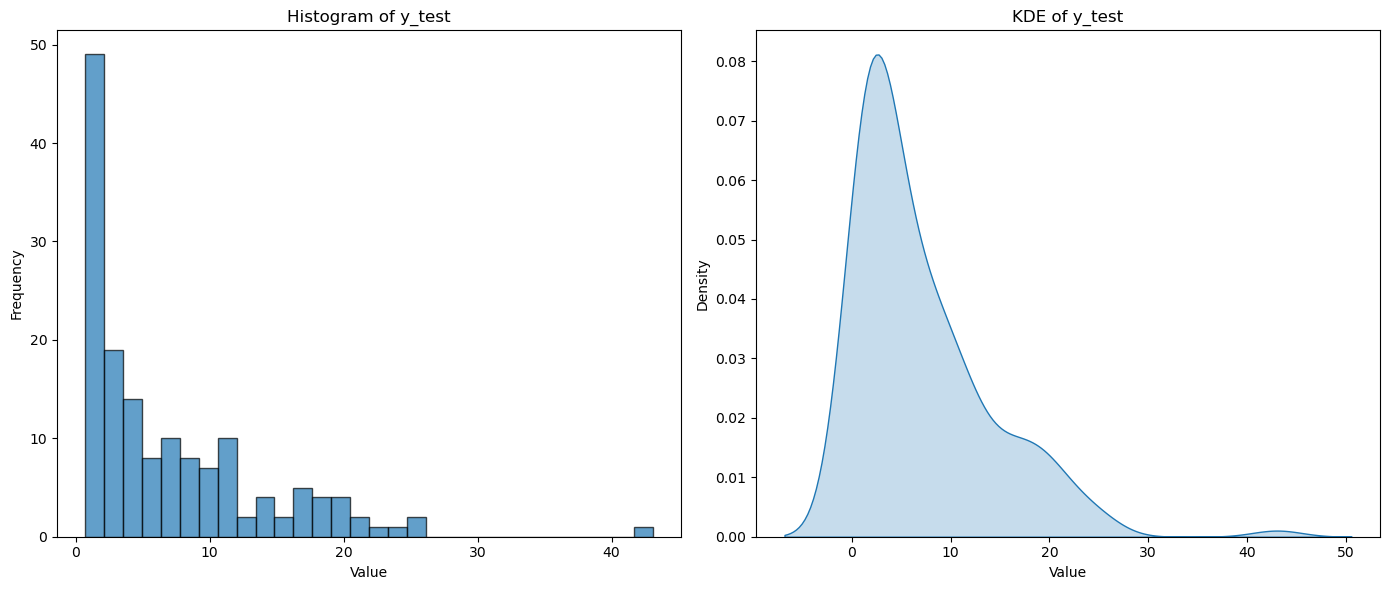

In [78]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model

In [79]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [80]:
linear_model.coef_, linear_model.intercept_

(array([ 2.17097202e+00,  3.42871580e-01, -7.02935191e-01,  1.28672677e+00,
        -7.06178873e-01,  7.51301729e-01,  6.40372715e+00,  4.12059674e+00,
         1.16824562e+00, -1.64030432e+00,  4.70538695e-01, -7.93914459e-04,
        -1.52105535e-01, -3.62683670e-01,  1.14322548e+00,  6.90515206e-01]),
 3.873133572955164)

In [81]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP,y_real,y_pred,err,%_err
444,0.019265,-1.224556,True,False,True,0.020367,0.061100,0.000000,0.000000,0.610998,-5.123578,-107.100712,-2.101448,0.978202,-1.719033,2.056748,1.479137,-1.415654,2.894791,195.708117
344,0.872343,-0.479032,False,True,False,0.073937,0.046211,0.046211,0.194085,0.942699,-0.018422,-47.650618,-1.067927,0.786380,0.569552,0.396378,4.160566,6.942982,-2.782415,-66.875879
47,-0.332473,-0.449046,True,False,False,0.104322,0.029806,0.000000,0.000000,1.281669,1.430782,-88.829599,-2.753179,-0.866314,-0.028302,0.573061,4.500000,2.301449,2.198551,48.856697
67,-0.194070,-0.170446,True,False,False,0.044643,0.059524,0.000000,0.000000,1.175595,1.195427,-88.883606,0.111770,-0.767335,1.134786,-0.298534,6.000000,3.162351,2.837649,47.294149
363,1.432180,-2.293026,True,True,False,0.045737,0.075139,0.075139,0.182947,0.891865,-1.271800,150.877752,-2.321509,-0.567917,-0.045412,-0.235736,8.321133,5.982056,2.339076,28.110072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.568354,1.046226,False,True,False,0.070000,0.045000,0.085000,0.180000,0.765000,-2.746601,44.430581,-0.370395,-0.983551,-0.490883,-0.367398,4.474045,11.182356,-6.708311,-149.938366
122,0.899570,1.225240,True,False,True,0.078201,0.097752,0.000000,0.039101,0.997067,0.190119,-53.287710,-0.347878,-0.087478,0.125052,-0.401460,0.745674,4.014127,-3.268453,-438.321841
260,2.358952,2.477630,False,True,False,0.078046,0.042800,0.103223,0.168681,1.163142,2.044398,242.464046,-0.932673,-0.326055,-1.531639,0.774097,10.688667,9.990902,0.697765,6.528084
23,3.064483,0.838518,False,True,False,0.052108,0.042634,0.080531,0.123164,0.990052,0.407225,55.306844,1.008299,-0.582113,0.335453,-0.051455,15.000000,11.817598,3.182402,21.216011


### Evaluation Metrics

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.767398419548045
MAPE: 0.7921303648041302
R^2: 0.6990282262333543


#### Correction for negative predictions

In [83]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [84]:
y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df_negcorr = X_test.copy()
results_df_negcorr["y_real"] = y_test
results_df_negcorr["y_pred"] = linear_y_pred
results_df_negcorr["err"] = results_df_negcorr["y_real"] - results_df_negcorr["y_pred"]
results_df_negcorr["%_err"] = results_df_negcorr["err"] / results_df_negcorr["y_real"] * 100
results_df_negcorr

,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP,y_real,y_pred,err,%_err
444,0.019265,-1.224556,True,False,True,0.020367,0.061100,0.000000,0.000000,0.610998,-5.123578,-107.100712,-2.101448,0.978202,-1.719033,2.056748,1.479137,0.604564,0.874573,59.127256
344,0.872343,-0.479032,False,True,False,0.073937,0.046211,0.046211,0.194085,0.942699,-0.018422,-47.650618,-1.067927,0.786380,0.569552,0.396378,4.160566,4.770001,-0.609434,-14.647866
47,-0.332473,-0.449046,True,False,False,0.104322,0.029806,0.000000,0.000000,1.281669,1.430782,-88.829599,-2.753179,-0.866314,-0.028302,0.573061,4.500000,2.024575,2.475425,55.009453
67,-0.194070,-0.170446,True,False,False,0.044643,0.059524,0.000000,0.000000,1.175595,1.195427,-88.883606,0.111770,-0.767335,1.134786,-0.298534,6.000000,3.145890,2.854110,47.568492
363,1.432180,-2.293026,True,True,False,0.045737,0.075139,0.075139,0.182947,0.891865,-1.271800,150.877752,-2.321509,-0.567917,-0.045412,-0.235736,8.321133,5.656592,2.664540,32.021367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.568354,1.046226,False,True,False,0.070000,0.045000,0.085000,0.180000,0.765000,-2.746601,44.430581,-0.370395,-0.983551,-0.490883,-0.367398,4.474045,7.264056,-2.790011,-62.359915
122,0.899570,1.225240,True,False,True,0.078201,0.097752,0.000000,0.039101,0.997067,0.190119,-53.287710,-0.347878,-0.087478,0.125052,-0.401460,0.745674,2.128475,-1.382801,-185.442993
260,2.358952,2.477630,False,True,False,0.078046,0.042800,0.103223,0.168681,1.163142,2.044398,242.464046,-0.932673,-0.326055,-1.531639,0.774097,10.688667,14.320747,-3.632080,-33.980662
23,3.064483,0.838518,False,True,False,0.052108,0.042634,0.080531,0.123164,0.990052,0.407225,55.306844,1.008299,-0.582113,0.335453,-0.051455,15.000000,9.433812,5.566188,37.107917


In [85]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.458337574077997
MAPE: 0.49820420328198056
R^2: 0.5785087498495033


### Evaluating per ranges

#### Testing 0-4 range values

In [86]:
range_min, range_max = 0, 4

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_negcorr['y_real_in_range'] = results_df_negcorr['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_negcorr['in_range'] = results_df_negcorr.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_negcorr['y_real_in_range'].sum()

correct_predictions = results_df_negcorr['in_range'].sum()

print(f'Number of real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of real values in the range 0-4: 70
Number of correct predictions in the range 0-4: 59


#### All ranges visualized with a bar plot

   Range  Total Real in_range  Correct Predictions
0    0-4                   70                   41
1    5-9                   24                   12
2  10-14                   16                    4
3  15-19                   11                    2
4  20-24                    6                    0
5  25-29                    1                    0
6  30-34                    0                    0
7  35-39                    0                    0
8    40+                    1                    0


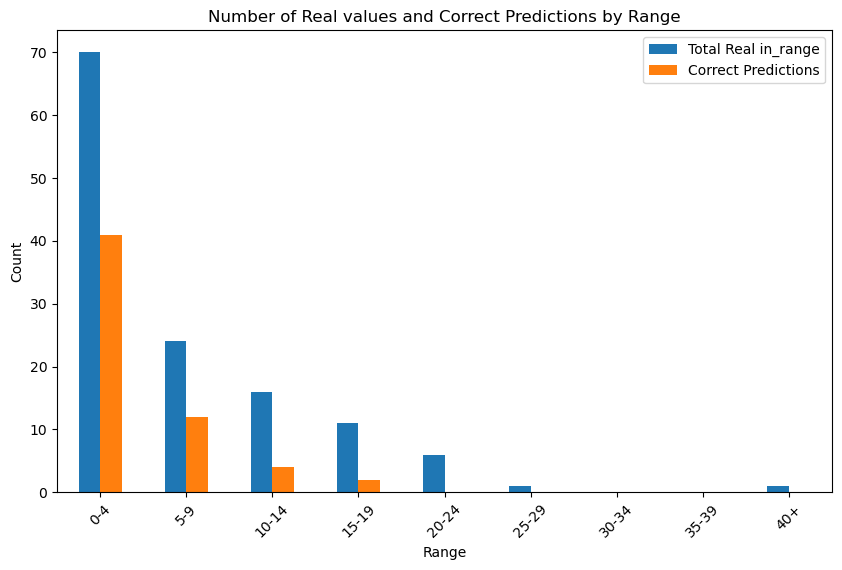

In [87]:
ranges = [ (0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in_range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Confusion Matrix


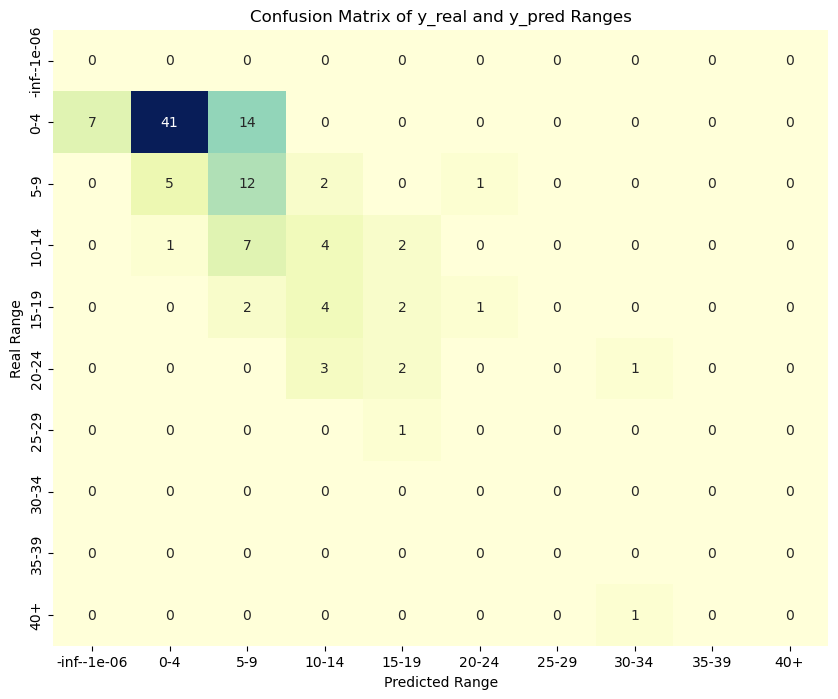

In [88]:
ranges = [(-float('inf'), -0.000001),(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, float('inf'))]

confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [89]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
-inf--1e-06: 0.00%
0-4: 66.13%
5-9: 60.00%
10-14: 28.57%
15-19: 22.22%
20-24: 0.00%
25-29: 0.00%
30-34: 0.00%
35-39: 0.00%
40+: 0.00%


As said at the start of this model, results will be kept in a table inside the final document. We saw its more appropriate to have a 70-30 distribution for this LM 

## Ridge Regression 

In [90]:
target = "AAV"
features = [col for col in df3.columns if col != target]
X, y = df3[features], df3[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (406, 16)
X_test shape: (102, 16)
y_train shape: (406,)
y_test shape: (102,)


In [91]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP,y_real,y_pred,err,%_err
444,0.019265,-1.224556,True,False,True,0.020367,0.061100,0.000000,0.000000,0.610998,-5.123578,-107.100712,-2.101448,0.978202,-1.719033,2.056748,1.479137,-1.381340,2.860477,193.388251
344,0.872343,-0.479032,False,True,False,0.073937,0.046211,0.046211,0.194085,0.942699,-0.018422,-47.650618,-1.067927,0.786380,0.569552,0.396378,4.160566,6.820085,-2.659519,-63.922033
47,-0.332473,-0.449046,True,False,False,0.104322,0.029806,0.000000,0.000000,1.281669,1.430782,-88.829599,-2.753179,-0.866314,-0.028302,0.573061,4.500000,2.624436,1.875564,41.679202
67,-0.194070,-0.170446,True,False,False,0.044643,0.059524,0.000000,0.000000,1.175595,1.195427,-88.883606,0.111770,-0.767335,1.134786,-0.298534,6.000000,3.028885,2.971115,49.518588
363,1.432180,-2.293026,True,True,False,0.045737,0.075139,0.075139,0.182947,0.891865,-1.271800,150.877752,-2.321509,-0.567917,-0.045412,-0.235736,8.321133,5.559658,2.761475,33.186283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,4.649118,1.430136,True,True,False,0.061271,0.051596,0.087069,0.174137,0.857788,-1.545439,154.837403,-0.659206,-1.245997,0.227335,-1.039201,19.536665,13.655936,5.880729,30.100988
224,1.898215,0.334268,True,False,False,0.053957,0.062950,0.017986,0.116906,0.971223,0.231394,-44.688141,-0.488116,-2.023646,0.659596,-2.315744,1.371416,6.572584,-5.201168,-379.255439
110,1.612395,0.653820,False,True,False,0.077486,0.051657,0.047353,0.193715,0.895394,-1.113935,77.026002,-0.513045,-0.679354,-0.030168,0.050914,9.445207,7.704172,1.741035,18.432996
428,2.181372,3.269964,True,False,False,0.105079,0.210158,0.000000,0.000000,2.451839,3.098285,-98.372334,0.346240,-0.545965,0.438237,-1.024866,16.566334,8.047007,8.519327,51.425540


### Evaluation Metrics (Ridge Regression)

In [92]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 3.752312799097525
MAPE: 0.6029819172039892
R^2: 0.585092452131606


#### Correction for negative predictions

In [93]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [94]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 4.555028871688474
MAPE: 0.44621255812137123
R^2: 0.3885857814567254


,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP,y_real,y_pred,err,%_err
444,0.019265,-1.224556,True,False,True,0.020367,0.061100,0.000000,0.000000,0.610998,-5.123578,-107.100712,-2.101448,0.978202,-1.719033,2.056748,1.479137,0.593462,0.885674,59.877788
344,0.872343,-0.479032,False,True,False,0.073937,0.046211,0.046211,0.194085,0.942699,-0.018422,-47.650618,-1.067927,0.786380,0.569552,0.396378,4.160566,4.726600,-0.566034,-13.604730
47,-0.332473,-0.449046,True,False,False,0.104322,0.029806,0.000000,0.000000,1.281669,1.430782,-88.829599,-2.753179,-0.866314,-0.028302,0.573061,4.500000,2.132083,2.367917,52.620380
67,-0.194070,-0.170446,True,False,False,0.044643,0.059524,0.000000,0.000000,1.175595,1.195427,-88.883606,0.111770,-0.767335,1.134786,-0.298534,6.000000,3.133114,2.866886,47.781436
363,1.432180,-2.293026,True,True,False,0.045737,0.075139,0.075139,0.182947,0.891865,-1.271800,150.877752,-2.321509,-0.567917,-0.045412,-0.235736,8.321133,5.112674,3.208459,38.557954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,4.649118,1.430136,True,True,False,0.061271,0.051596,0.087069,0.174137,0.857788,-1.545439,154.837403,-0.659206,-1.245997,0.227335,-1.039201,19.536665,9.972735,9.563931,48.953752
224,1.898215,0.334268,True,False,False,0.053957,0.062950,0.017986,0.116906,0.971223,0.231394,-44.688141,-0.488116,-2.023646,0.659596,-2.315744,1.371416,4.358549,-2.987133,-217.813829
110,1.612395,0.653820,False,True,False,0.077486,0.051657,0.047353,0.193715,0.895394,-1.113935,77.026002,-0.513045,-0.679354,-0.030168,0.050914,9.445207,7.526755,1.918452,20.311382
428,2.181372,3.269964,True,False,False,0.105079,0.210158,0.000000,0.000000,2.451839,3.098285,-98.372334,0.346240,-0.545965,0.438237,-1.024866,16.566334,4.394463,12.171870,73.473531


#### Testing 0-4 range values

In [95]:
range_min, range_max = 0, 4

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-4: 43
Number of correct predictions in the range 0-4: 37


   Range  Total Real in range  Correct_Predictions
0    0-4                   43                   37
1    5-9                   20                    7
2  10-14                   10                    0
3  15-19                    8                    1
4  20-24                    5                    0
5  25-29                    0                    0
6  30-34                    0                    0
7  35-39                    0                    0
8  40-44                    0                    0


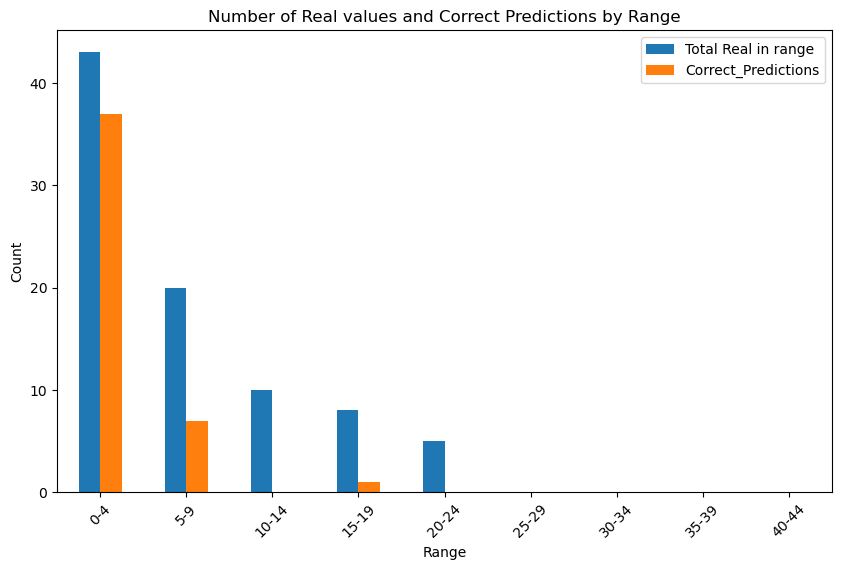

In [96]:
ranges = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, 44)]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

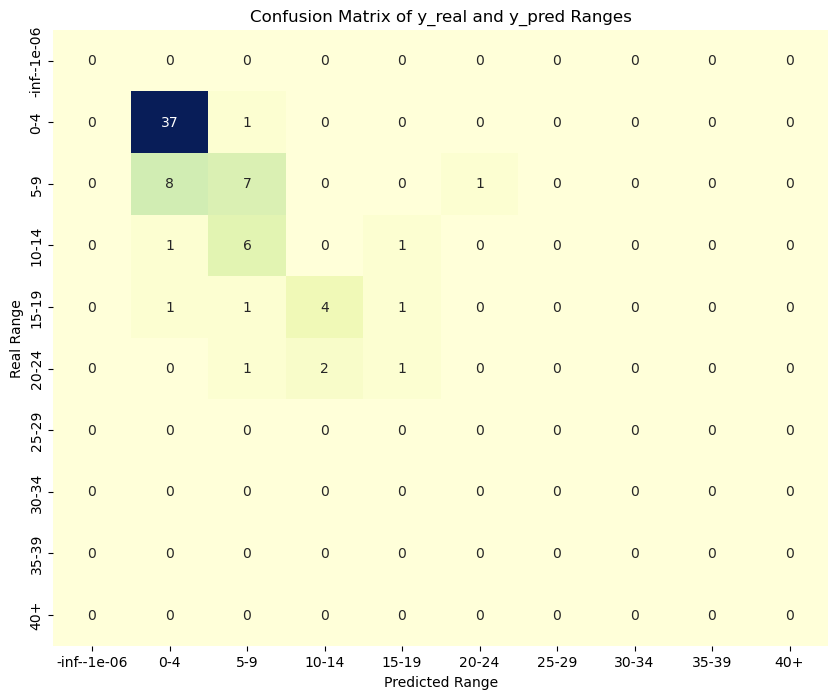

In [97]:
ranges = [(-float('inf'), -0.000001),(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, float('inf'))]

confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [98]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
-inf--1e-06: 0.00%
0-4: 97.37%
5-9: 43.75%
10-14: 0.00%
15-19: 14.29%
20-24: 0.00%
25-29: 0.00%
30-34: 0.00%
35-39: 0.00%
40+: 0.00%


## XGBoost Regression

In [99]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,Acc_WAR,Acc_WPA,RP,SP,minor_league,Acc_W/Acc_IP,Acc_L/Acc_IP,Acc_QS/Acc_IP,Acc_GS/Acc_IP,Acc_SO/Acc_IP,K/9_combined,W/L/IP_combined,xFIP_2-SIERA_2,ERA-WHIP,SIERA-xFIP,xERA-FIP,y_real,y_pred,err,%_err
444,0.019265,-1.224556,True,False,True,0.020367,0.061100,0.000000,0.000000,0.610998,-5.123578,-107.100712,-2.101448,0.978202,-1.719033,2.056748,1.479137,0.658190,0.820947,55.501756
344,0.872343,-0.479032,False,True,False,0.073937,0.046211,0.046211,0.194085,0.942699,-0.018422,-47.650618,-1.067927,0.786380,0.569552,0.396378,4.160566,6.386150,-2.225584,-53.492329
47,-0.332473,-0.449046,True,False,False,0.104322,0.029806,0.000000,0.000000,1.281669,1.430782,-88.829599,-2.753179,-0.866314,-0.028302,0.573061,4.500000,2.670109,1.829891,40.664254
67,-0.194070,-0.170446,True,False,False,0.044643,0.059524,0.000000,0.000000,1.175595,1.195427,-88.883606,0.111770,-0.767335,1.134786,-0.298534,6.000000,3.803109,2.196891,36.614851
363,1.432180,-2.293026,True,True,False,0.045737,0.075139,0.075139,0.182947,0.891865,-1.271800,150.877752,-2.321509,-0.567917,-0.045412,-0.235736,8.321133,8.424573,-0.103440,-1.243100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,4.649118,1.430136,True,True,False,0.061271,0.051596,0.087069,0.174137,0.857788,-1.545439,154.837403,-0.659206,-1.245997,0.227335,-1.039201,19.536665,15.806348,3.730317,19.093931
224,1.898215,0.334268,True,False,False,0.053957,0.062950,0.017986,0.116906,0.971223,0.231394,-44.688141,-0.488116,-2.023646,0.659596,-2.315744,1.371416,7.551806,-6.180390,-450.657713
110,1.612395,0.653820,False,True,False,0.077486,0.051657,0.047353,0.193715,0.895394,-1.113935,77.026002,-0.513045,-0.679354,-0.030168,0.050914,9.445207,7.025632,2.419575,25.616963
428,2.181372,3.269964,True,False,False,0.105079,0.210158,0.000000,0.000000,2.451839,3.098285,-98.372334,0.346240,-0.545965,0.438237,-1.024866,16.566334,8.622543,7.943790,47.951408


### Evaluation Metrics (XGBoost Regression)

In [100]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.328115440073992
MAPE: 0.5740527749906127
R^2: 0.4479849255656232


In [101]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


#### Testing 0-4 range values

In [102]:
range_min, range_max = 0, 4

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-4: 43
Number of correct predictions in the range 0-4: 29


#### All ranges visualized with a bar plot

   Range  Total_y_real_in_range  Correct_Predictions
0    0-4                     70                   41
1    5-9                     24                   12
2  10-14                     16                    4
3  15-19                     11                    2
4  20-24                      6                    0
5  25-29                      1                    0
6  30-34                      0                    0
7  35-39                      0                    0
8    40+                      1                    0


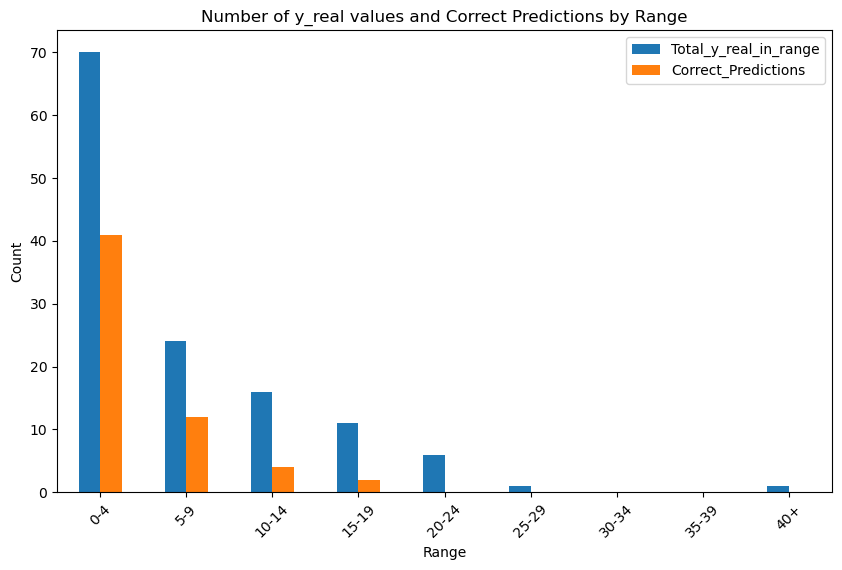

In [103]:
ranges = [ (0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

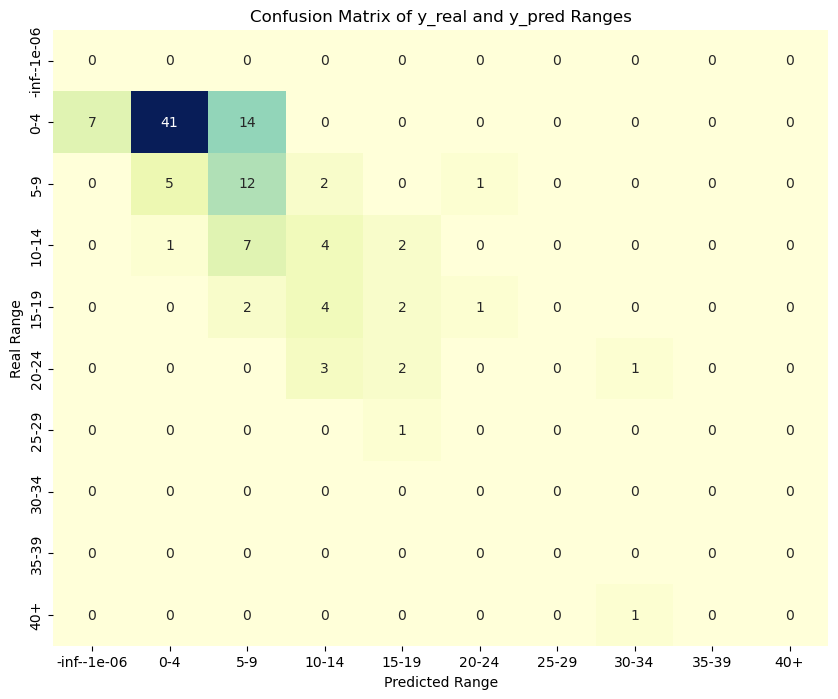

In [104]:
ranges = [(-float('inf'), -0.000001),(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, float('inf'))]

confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [105]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
-inf--1e-06: 0.00%
0-4: 66.13%
5-9: 60.00%
10-14: 28.57%
15-19: 22.22%
20-24: 0.00%
25-29: 0.00%
30-34: 0.00%
35-39: 0.00%
40+: 0.00%
